# Paso 1 Recuperación de Datos de Prueba
Recuperar el archivo CSV que contiene el x_test_file, y_test_file, los cuales fueron utilizados para probar el modelo.

In [1]:
from pathlib import Path
import pandas as pd

x_path = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\Xtest_processed.csv")
y_path = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\ytest_processed.csv")

X_test = pd.read_csv(x_path)
y_test = pd.read_csv(y_path)

print(X_test.shape, y_test.shape)
display(X_test.head(), y_test.head())


(157, 94) (157, 2)


,cat__X1_0.64,cat__X1_0.66,cat__X1_0.69,cat__X1_0.71,cat__X1_0.74,cat__X1_0.76,cat__X1_0.79,cat__X1_0.82,cat__X1_0.86,cat__X1_0.9,...,cat__X7_422.25,cat__X7_516.0,cat__X8_1.0,cat__X8_2.0,cat__X8_3.0,cat__X8_4.0,cat__X8_5.0,cat__X8_155.0,cat__X8_440.0,cat__X8_971.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,Y1,Y2
0,1.270369,1.220216
1,0.777034,0.550270
2,1.140085,0.943339
3,0.712927,0.660919
4,-1.354473,-1.240035


# Paso 2 Genera Conjunto de Datos Sintéticos
Genera X_drift (y opcionalmente y_drift) preservando los tipos de variables de X_test/y_test <br>
y aplicando drifts controlados por tipo (numéricas vs. categóricas).<br>

**RESUMEN**<br>
Detecta columnas numéricas y categóricas de X_test y preserva sus tipos en X_drift.<br>

Aplica drifts con base al tipo de dato:<br>
**Numéricas**: shift de media, escala de varianza y faltantes.<br>
**Categóricas**: reponderación de categorías (cambia proporciones) y faltantes.<br>

Guarda Xdrift_processed.csv y ydrift_processed.csv en carpeta processed.

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

# --- Guard: cargar X_test / y_test si no existen en memoria ---
if "X_test" not in globals() or "y_test" not in globals():
    X_PATH = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\Xtest_processed.csv")
    Y_PATH = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\ytest_processed.csv")
    X_test = pd.read_csv(X_PATH)
    y_test = pd.read_csv(Y_PATH)

OUT_DIR = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
X_OUT_PATH = OUT_DIR / "Xdrift_processed.csv"
Y_OUT_PATH = OUT_DIR / "ydrift_processed.csv"

rng = np.random.default_rng(123)

# ---------- Clasificación de columnas ----------
def is_binary_dummy(s: pd.Series) -> bool:
    if not np.issubdtype(s.dtype, np.number):
        return False
    vals = pd.unique(s.dropna())
    return len(vals) <= 2 and set(np.round(vals, 6)).issubset({0.0, 1.0})

def is_lowcard_numeric(s: pd.Series) -> bool:
    return np.issubdtype(s.dtype, np.number) and (3 <= s.nunique(dropna=True) <= 15)

def is_continuous_numeric(s: pd.Series) -> bool:
    return np.issubdtype(s.dtype, np.number) and (s.nunique(dropna=True) > 15)

binary_cols = [c for c in X_test.columns if is_binary_dummy(X_test[c])]
lowcard_cols = [c for c in X_test.columns if is_lowcard_numeric(X_test[c])]
cont_cols   = [c for c in X_test.columns if is_continuous_numeric(X_test[c])]

print(f"[INFO] binarios={len(binary_cols)} | baja_card={len(lowcard_cols)} | continuos={len(cont_cols)}")

# ---------- Selección de subconjunto a driftear (suave) ----------
FRACTION_COLUMNS_TO_DRIFT = 0.25  # afecta ~25% de columnas por tipo (ajusta si deseas)
n_bin = max(1, int(len(binary_cols)   * FRACTION_COLUMNS_TO_DRIFT)) if binary_cols else 0
n_low = max(1, int(len(lowcard_cols) * FRACTION_COLUMNS_TO_DRIFT)) if lowcard_cols else 0
n_con = max(1, int(len(cont_cols)    * FRACTION_COLUMNS_TO_DRIFT)) if cont_cols else 0

bin_cols_to_drift = list(rng.choice(binary_cols, size=n_bin, replace=False)) if n_bin else []
low_cols_to_drift = list(rng.choice(lowcard_cols, size=n_low, replace=False)) if n_low else []
con_cols_to_drift = list(rng.choice(cont_cols, size=n_con, replace=False)) if n_con else []

print("[INFO] Columnas con drift (binarias):", len(bin_cols_to_drift))
print("[INFO] Columnas con drift (baja_card):", len(low_cols_to_drift))
print("[INFO] Columnas con drift (continuas):", len(con_cols_to_drift))

X_drift = X_test.copy()
y_drift = y_test.copy()   # por defecto no alteramos labels

# ---------- 1) Dummies 0/1: prevalencia suave ----------
GAMMA_REWEIGHT   = 0.08   # antes 0.25 → drift tenue
MISSING_BIN_FRAC = 0.00   # mantén 0 para no introducir NaN

for c in bin_cols_to_drift:
    col = X_test[c].astype(float)
    p = float(col.mean())
    p_prime = (1 - GAMMA_REWEIGHT) * p + GAMMA_REWEIGHT * (1 - p)
    X_drift[c] = rng.binomial(1, p_prime, size=len(X_test)).astype(col.dtype)
    if MISSING_BIN_FRAC > 0:
        m = int(MISSING_BIN_FRAC * len(X_drift))
        if m > 0:
            idx = rng.choice(len(X_drift), size=m, replace=False)
            X_drift.loc[X_drift.index[idx], c] = np.nan

# ---------- 2) Numéricas baja cardinalidad: reponderación suave ----------
LOWCARD_MISS_FRAC = 0.005     # antes 0.02
LOWCARD_UNIFORM_MIX = 0.15    # antes 0.30 → ahora 15% hacia uniforme

for c in low_cols_to_drift:
    s = X_test[c]
    counts = s.value_counts(normalize=True)
    cats = counts.index.values
    p = counts.values
    uniform = np.ones_like(p) / len(p)
    q = (1 - LOWCARD_UNIFORM_MIX) * p + LOWCARD_UNIFORM_MIX * uniform
    q = q / q.sum()
    X_drift[c] = rng.choice(cats, size=len(s), replace=True, p=q).astype(s.dtype)
    m = int(LOWCARD_MISS_FRAC * len(X_drift))
    if m > 0:
        idx = rng.choice(len(X_drift), size=m, replace=False)
        X_drift.loc[X_drift.index[idx], c] = np.nan

# ---------- 3) Continuas: mean-shift y varianza suaves ----------
MEAN_SHIFT_STD = 0.20   # antes 0.6
VAR_SCALE      = 1.08   # antes 1.3
CONT_MISS_FRAC = 0.005  # antes 0.05

for c in con_cols_to_drift:
    s = X_test[c].astype(float)
    mu, sd = s.mean(), s.std(ddof=0)
    if np.isfinite(sd) and sd > 0:
        # pequeño desplazamiento de media + ligera expansión
        x = s + MEAN_SHIFT_STD * sd
        X_drift[c] = mu + (x - mu) * VAR_SCALE
    else:
        X_drift[c] = s
    m = int(CONT_MISS_FRAC * len(X_drift))
    if m > 0:
        idx = rng.choice(len(X_drift), size=m, replace=False)
        X_drift.loc[X_drift.index[idx], c] = np.nan

# ---------- Guardado ----------
X_drift.to_csv(X_OUT_PATH, index=False)
y_drift.to_csv(Y_OUT_PATH, index=False)

print("\n[OK] Drift SUAVE generado y guardado:")
print("  X_drift ->", X_OUT_PATH)
print("  y_drift ->", Y_OUT_PATH)

# Resumen simple de magnitud (opcional)
def quick_drift_summary(df_base, df_drift, cols):
    out = []
    for c in cols:
        a = df_base[c].dropna().astype(float)
        b = df_drift[c].dropna().astype(float)
        if len(a)>1 and len(b)>1:
            out.append({"col": c, "mean_diff": float(b.mean()-a.mean()), "std_ratio": float(b.std(ddof=0)/max(1e-12,a.std(ddof=0)))})
    return pd.DataFrame(out)

summary_cols = bin_cols_to_drift[:3] + low_cols_to_drift[:3] + con_cols_to_drift[:3]
print("\n[INFO] Chequeo rápido de magnitud de drift en una muestra de columnas:")
display(quick_drift_summary(X_test, X_drift, summary_cols))


[INFO] binarios=94 | baja_card=0 | continuos=0
[INFO] Columnas con drift (binarias): 23
[INFO] Columnas con drift (baja_card): 0
[INFO] Columnas con drift (continuas): 0

[OK] Drift SUAVE generado y guardado:
  X_drift -> C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\Xdrift_processed.csv
  y_drift -> C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\ydrift_processed.csv

[INFO] Chequeo rápido de magnitud de drift en una muestra de columnas:


,col,mean_diff,std_ratio
0,cat__X4_122.5,0.031847,1.056034e+00
1,cat__X2_1297.5,0.089172,2.849918e+11
2,cat__X7_0.1,0.101911,1.066590e+00


# Paso 3 Recuperación del Modelos que esta en Producción
Recuperamos el archivo **xgb_multioutput.pkl** del modelo que se encuentra en producción, que sabemos que es el mejor.<br> 

Este modelo le llamaremos el modelo congelado.

In [15]:
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Importaciones necesarias para la deserialización del modelo
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# Ruta del modelo congelado
MODEL_PATH = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\models\xgb_multioutput.pkl")

# Cargar el modelo
print(f"[INFO] Cargando modelo congelado desde: {MODEL_PATH}")
model = joblib.load(MODEL_PATH)

print("[OK] Modelo congelado cargado correctamente y listo para evaluación.")
print(f"Tipo de modelo cargado: {type(model)}")


[INFO] Cargando modelo congelado desde: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\models\xgb_multioutput.pkl
[OK] Modelo congelado cargado correctamente y listo para evaluación.
Tipo de modelo cargado: <class 'sklearn.multioutput.MultiOutputRegressor'>


# Paso 4 – Evaluación para Detectar Drift

## La evaluación incluirá:
4.6 Disparo de alertas si se sobrepasan umbrales definidos de degradación o drift.

## 4.1 Evaluación de desempeño del modelo (MSE, MAE, R²)
Se evalúa el modelo congelado, tanto en el conjunto de datos original (X_test, y_test),<br> 
así como, en el conjunto de datos drift (X_drift, y_drift), <br>
y presenta una comparación de resultados.<br>

**RESUMEN**<br>
Este paso mide si el modelo sigue funcionando bien ante los nuevos datos. <br>
En este caso los nuevos datos son el set sintético con drift. <br>

In [17]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Evaluación sobre conjunto BASE (X_test / y_test) ===
print("[INFO] Evaluando modelo en conjunto BASE (Test)...")
y_pred_base = model.predict(X_test)
y_true_base = y_test.values if isinstance(y_test, pd.DataFrame) else y_test

mse_base = mean_squared_error(y_true_base, y_pred_base)
mae_base = mean_absolute_error(y_true_base, y_pred_base)
r2_base = r2_score(y_true_base, y_pred_base)

# === Evaluación sobre conjunto DRIFT (X_drift / y_drift) ===
print("\n[INFO] Evaluando modelo en conjunto DRIFT (Sintético)...")
y_pred_drift = model.predict(X_drift)
y_true_drift = y_drift.values if isinstance(y_drift, pd.DataFrame) else y_drift

mse_drift = mean_squared_error(y_true_drift, y_pred_drift)
mae_drift = mean_absolute_error(y_true_drift, y_pred_drift)
r2_drift = r2_score(y_true_drift, y_pred_drift)

# === Comparación de métricas ===
metrics_df = pd.DataFrame({
    "Dataset": ["Baseline (Test)", "Drift (Sintético)"],
    "MSE": [mse_base, mse_drift],
    "MAE": [mae_base, mae_drift],
    "R²": [r2_base, r2_drift]
})

print("\n=== Resultados de desempeño del modelo ===")
display(metrics_df)

# === Alerta básica de pérdida de desempeño ===
R2_THRESHOLD = 0.05   # pérdida de R² > 5%
MSE_INCREASE_THRESHOLD = 0.10  # aumento de MSE > 10%

r2_drop = r2_base - r2_drift
mse_increase = (mse_drift - mse_base) / mse_base if mse_base != 0 else 0

alertas = []
if r2_drop > R2_THRESHOLD:
    alertas.append(f"Pérdida significativa de R²: {r2_drop:.3f}")
if mse_increase > MSE_INCREASE_THRESHOLD:
    alertas.append(f"Aumento en MSE de {mse_increase*100:.1f}%")

if alertas:
    print("\n⚠️ ALERTA DE PÉRDIDA DE DESEMPEÑO DETECTADA:")
    for a in alertas:
        print(" -", a)
else:
    print("\n✅ Desempeño del modelo estable. No se detecta degradación significativa.")


[INFO] Evaluando modelo en conjunto BASE (Test)...

[INFO] Evaluando modelo en conjunto DRIFT (Sintético)...

=== Resultados de desempeño del modelo ===


,Dataset,MSE,MAE,R²
0,Baseline (Test),0.194120,0.180912,0.827266
1,Drift (Sintético),0.760541,0.591243,0.326739



⚠️ ALERTA DE PÉRDIDA DE DESEMPEÑO DETECTADA:
 - Pérdida significativa de R²: 0.501
 - Aumento en MSE de 291.8%


# Paso 4.2 Pruebas Estadísticas de Drift (KS/Chi²) entre X_test y X_drift
Aquí ya no se evalúa el modelo congelado, sino los datos mismos. <br>
El objetivo es, saber si la distribución de entrada (nuevos datos[drift]) (features [X]), <br>
ha cambiado significativamente respecto a la distribución original.

Se detectan automáticamente columnas numéricas y categóricas, <br> 
aplica Kolmogorov–Smirnov (KS) a numéricas y Chi-cuadrado (Chi²) a categóricas, <br> 
y devuelve un resumen con p-values, estadísticos y banderas de drift.<br>

**RESUMEN**<br>
Separa numéricas y categóricas automáticamente.<br>
Aplica KS a cada numérica y Chi² a cada categórica.<br>
Opción de Bonferroni (desactivada por defecto) para múltiples pruebas.<br>
Devuelve un DataFrame drift_report con estadísticos, p-values, fracción de faltantes y número de valores únicos en cada dataset.<br>
Lista final de columnas con drift significativo (p < alpha).<br>


In [19]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency

# Parámetros de significancia
ALPHA = 0.05            # umbral de significancia (p < ALPHA -> drift)
USE_BONFERRONI = False  # si True, ajusta ALPHA dividiendo por #tests por tipo. (desactivada por defecto)

# Identificar tipos de columnas
num_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_test.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# (Por seguridad) Asegurar mismas columnas en ambos datasets
common_cols = [c for c in X_test.columns if c in X_drift.columns]
num_cols = [c for c in num_cols if c in common_cols]
cat_cols = [c for c in cat_cols if c in common_cols]

results = []

# --- Kolmogorov–Smirnov (KS) para numéricas ---
alpha_num = ALPHA / max(1, len(num_cols)) if USE_BONFERRONI else ALPHA
for c in num_cols:
    a = X_test[c].dropna().values
    b = X_drift[c].dropna().values
    # Condiciones mínimas
    if len(a) < 2 or len(b) < 2:
        stat, p = np.nan, np.nan
    else:
        stat, p = ks_2samp(a, b, alternative='two-sided', mode='auto')

    results.append({
        "feature": c,
        "type": "numeric",
        "test": "KS",
        "statistic": stat,
        "p_value": p,
        "alpha": alpha_num,
        "drift_detected": (p < alpha_num) if np.isfinite(p) else False,
        "missing_frac_base": X_test[c].isna().mean(),
        "missing_frac_drift": X_drift[c].isna().mean(),
        "n_unique_base": X_test[c].nunique(dropna=True),
        "n_unique_drift": X_drift[c].nunique(dropna=True),
    })

# --- Chi-cuadrado (Chi²) para categóricas ---
alpha_cat = ALPHA / max(1, len(cat_cols)) if USE_BONFERRONI else ALPHA
for c in cat_cols:
    # Tablas de frecuencias
    base_counts = X_test[c].astype("category")
    drift_counts = X_drift[c].astype("category")
    # Alinear categorías (unión de categorías)
    cats = list(set(base_counts.cat.categories).union(set(drift_counts.cat.categories)))
    base_ct = base_counts.cat.set_categories(cats)
    drift_ct = drift_counts.cat.set_categories(cats)

    base_freq = base_ct.value_counts(sort=False)
    drift_freq = drift_ct.value_counts(sort=False)
    contingency = np.vstack([base_freq.values, drift_freq.values])

    # Requisitos: al menos 2 categorías con conteo > 0
    if (contingency.sum(axis=0) > 0).sum() < 2:
        chi2, p, dof = np.nan, np.nan, np.nan
    else:
        chi2, p, dof, _ = chi2_contingency(contingency)

    results.append({
        "feature": c,
        "type": "categorical",
        "test": "Chi2",
        "statistic": chi2,
        "p_value": p,
        "alpha": alpha_cat,
        "drift_detected": (p < alpha_cat) if np.isfinite(p) else False,
        "missing_frac_base": X_test[c].isna().mean(),
        "missing_frac_drift": X_drift[c].isna().mean(),
        "n_unique_base": int((contingency[0] > 0).sum()) if np.ndim(contingency)==2 else np.nan,
        "n_unique_drift": int((contingency[1] > 0).sum()) if np.ndim(contingency)==2 else np.nan,
    })

drift_report = pd.DataFrame(results).sort_values(["type", "p_value"], na_position="last").reset_index(drop=True)

print(f"[INFO] KS aplicado a {len(num_cols)} columna(s) numérica(s).")
print(f"[INFO] Chi² aplicado a {len(cat_cols)} columna(s) categórica(s).")
print(f"[INFO] Umbral alpha (num): {alpha_num} | alpha (cat): {alpha_cat}")

print("\n=== Resumen de pruebas de drift (p-valor) ===")
display(drift_report.head(20))

# Vista de columnas con drift significativo
drift_hits = drift_report[drift_report["drift_detected"] == True]
print(f"\n[RESULT] Columnas con drift detectado: {len(drift_hits)}")
display(drift_hits[["feature","type","test","statistic","p_value","missing_frac_base","missing_frac_drift"]])


[INFO] KS aplicado a 94 columna(s) numérica(s).
[INFO] Chi² aplicado a 0 columna(s) categórica(s).
[INFO] Umbral alpha (num): 0.05 | alpha (cat): 0.05

=== Resumen de pruebas de drift (p-valor) ===


,feature,type,test,statistic,p_value,alpha,drift_detected,missing_frac_base,missing_frac_drift,n_unique_base,n_unique_drift
0,cat__X1_49.5,numeric,KS,0.121019,0.200799,0.05,False,0.0,0.0,1,2
1,cat__X7_0.1,numeric,KS,0.101911,0.389698,0.05,False,0.0,0.0,2,2
2,cat__X1_0.74,numeric,KS,0.095541,0.471901,0.05,False,0.0,0.0,2,2
3,cat__X2_808.5,numeric,KS,0.089172,0.561864,0.05,False,0.0,0.0,2,2
4,cat__X2_1297.5,numeric,KS,0.089172,0.561864,0.05,False,0.0,0.0,1,2
5,cat__X1_0.66,numeric,KS,0.082803,0.656414,0.05,False,0.0,0.0,2,2
6,cat__X6_776.0,numeric,KS,0.082803,0.656414,0.05,False,0.0,0.0,1,2
7,cat__X6_44.0,numeric,KS,0.076433,0.750512,0.05,False,0.0,0.0,1,2
8,cat__X3_1174.0,numeric,KS,0.070064,0.837310,0.05,False,0.0,0.0,1,2
9,cat__X6_252.0,numeric,KS,0.063694,0.909101,0.05,False,0.0,0.0,1,2



[RESULT] Columnas con drift detectado: 0


,feature,type,test,statistic,p_value,missing_frac_base,missing_frac_drift


## 4.3 Identificar Columnas con Drift Significativo
Detecta qué variables (features [X]) están mostrando un cambio estadísticamente significativo entre el <br>
conjunto base (X_test) y el conjunto de monitoreo (X_drift).<br>
Es decir, ¿Qué columnas realmente están moviendose (drift) y pueden ser responsables de la degradación del modelo?<br>

**RESUMEN**<br>
Usa DataFrame drift_report del Paso 4.2 para filtrar columnas con drift (p < alpha).<br>
Clasifica severidad (mild/moderate/severe) usando KS para numéricas y p-value para categóricas.<br>
Genera un ranking mixto con un drift_score comparable entre tipos (KS vs −log10 p).<br>
Deja listas DRIFTED_NUM_COLS, DRIFTED_CAT_COLS y DRIFTED_ALL_COLS para usar en los pasos 4.5 (visualizaciones) y 4.6 (alertas/acciones).<br>

In [21]:
import pandas as pd
import numpy as np

# Verificación mínima
if "drift_report" not in globals():
    raise RuntimeError("No se encontró 'drift_report'. Ejecuta antes el Paso 4.2.")

# Parámetros
TOP_K = 15  # para mostrar las columnas más afectadas

# Reglas de severidad:
# - Numéricas (KS): usamos el estadístico KS (0–1)
# - Categóricas (Chi²): usamos p-value (inverso para severidad)
def classify_severity(row):
    if row["type"] == "numeric":
        ks = row["statistic"]
        if not np.isfinite(ks): 
            return "unknown"
        if ks >= 0.30: return "severe"
        if ks >= 0.20: return "moderate"
        if ks >= 0.10: return "mild"
        return "low"
    else:  # categorical
        p = row["p_value"]
        if not np.isfinite(p):
            return "unknown"
        if p < 1e-6: return "severe"
        if p < 1e-4: return "moderate"
        if p < 1e-2: return "mild"
        return "low"

drift_report = drift_report.copy()
drift_report["severity"] = drift_report.apply(classify_severity, axis=1)

# Filtrar solo columnas con drift (p < alpha ya calculado en Paso 4.2)
drift_hits = drift_report[drift_report["drift_detected"] == True].copy()

# Ranking: numéricas por KS desc, categóricas por p asc
numeric_hits = drift_hits[drift_hits["type"] == "numeric"].sort_values(
    by=["statistic"], ascending=False
)
categorical_hits = drift_hits[drift_hits["type"] == "categorical"].sort_values(
    by=["p_value"], ascending=True
)

# Un Top-K mixto (ordenando por una "score" homogénea)
# Para comparar numérico vs categórico, creamos un score donde:
# - Numérico: score = KS
# - Categórico: score = -log10(p_value)
score = []
for i, r in drift_hits.iterrows():
    if r["type"] == "numeric":
        s = r["statistic"]  # KS
    else:
        p = r["p_value"] if np.isfinite(r["p_value"]) and r["p_value"]>0 else 1e-300
        s = -np.log10(p)
    score.append(s)
drift_hits["drift_score"] = score

top_hits = drift_hits.sort_values(by="drift_score", ascending=False).head(TOP_K)

print(f"[INFO] Columnas con drift significativo: {len(drift_hits)}")
print("[TOP] Variables con mayor señal de drift (mixto):")
display(top_hits[[
    "feature","type","test","statistic","p_value","alpha","severity",
    "missing_frac_base","missing_frac_drift","n_unique_base","n_unique_drift","drift_score"
]])

print("\n[NUM] Variables numéricas con drift (ordenadas por KS desc):")
display(numeric_hits[[
    "feature","test","statistic","p_value","alpha","severity","missing_frac_base","missing_frac_drift"
]].head(TOP_K))

print("\n[CAT] Variables categóricas con drift (ordenadas por p asc):")
display(categorical_hits[[
    "feature","test","statistic","p_value","alpha","severity","missing_frac_base","missing_frac_drift"
]].head(TOP_K))

# Listas listas para usar en pasos posteriores (visualización/acciones)
DRIFTED_NUM_COLS = numeric_hits["feature"].tolist()
DRIFTED_CAT_COLS = categorical_hits["feature"].tolist()
DRIFTED_ALL_COLS = drift_hits["feature"].tolist()

print("\n[RESULT] DRIFTED_NUM_COLS:", DRIFTED_NUM_COLS[:10])
print("[RESULT] DRIFTED_CAT_COLS:", DRIFTED_CAT_COLS[:10])
print("[RESULT] Total columnas con drift:", len(DRIFTED_ALL_COLS))


[INFO] Columnas con drift significativo: 0
[TOP] Variables con mayor señal de drift (mixto):


,feature,type,test,statistic,p_value,alpha,severity,missing_frac_base,missing_frac_drift,n_unique_base,n_unique_drift,drift_score



[NUM] Variables numéricas con drift (ordenadas por KS desc):


,feature,test,statistic,p_value,alpha,severity,missing_frac_base,missing_frac_drift



[CAT] Variables categóricas con drift (ordenadas por p asc):


,feature,test,statistic,p_value,alpha,severity,missing_frac_base,missing_frac_drift



[RESULT] DRIFTED_NUM_COLS: []
[RESULT] DRIFTED_CAT_COLS: []
[RESULT] Total columnas con drift: 0


## 4.4 Unificar los Resultados (métricas + pruebas estadísticas)
Unifica los resultados (métricas + pruebas estadísticas), es el puente final del análisis de drift,<br>
donde se integran todas las piezas de evidencia anteriores.<br>

### **Integra**<br>

### MÉTRICAS
El impacto en el desempeño del modelo (del paso 4.1).<br>
Aplicamos métricas MSE, MAE, R2 a los resultados del MODELO con daos de prueba y datos sinteticos DRIFT.<br>

### ESTADÍSTICAS
El nivel de drift estadístico en los datos (del paso 4.2 y 4.3).<br>
Aplicamos KS y Chi² a los datos originales TEST y los nuevos datos DRIFT.
Determianmos que columnas muestran cambios significativos.

Es decir, conecta el “qué cambió” con el “qué efecto tuvo”.<br>

**RESUMEN**
Un DataFrame unificado con variaciones de desempeño (ΔR², %ΔMSE, %ΔMAE) y estadísticas de drift (columnas evaluadas, detectadas, tasa de drift).
Un flag de alerta global y una recomendación de acción.
Archivos CSV con: métricas comparativas, reporte de drift y el resumen unificado (listos para versionar con DVC/MLflow si lo deseas).

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- Verificaciones mínimas ---
needed_vars = ["metrics_df", "mse_base", "mse_drift", "mae_base", "mae_drift", "r2_base", "r2_drift", "drift_report"]
missing = [v for v in needed_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables previas: {missing}. Ejecuta 4.1 y 4.2/4.3 antes de 4.4.")

# --- Umbrales de desempeño (los mismos que en 4.1, ajusta si lo deseas) ---
R2_THRESHOLD = 0.05               # pérdida de R² > 5%
MSE_INCREASE_THRESHOLD = 0.10      # aumento relativo de MSE > 10%
MAE_INCREASE_THRESHOLD = 0.10      # aumento relativo de MAE > 10%

# --- Umbrales de drift (alineado con enfoque tipo Alibi Detect) ---
#   - Alerta si la tasa de columnas con drift supera 20% o si hay ≥ 3 columnas con drift.
ALPHA = drift_report["alpha"].dropna().unique()[0] if "alpha" in drift_report.columns else 0.05
DRIFT_RATE_THRESHOLD = 0.20
MIN_DRIFTED_FEATURES = 3

# --- Cálculo de variaciones de desempeño ---
r2_drop = float(r2_base - r2_drift)
mse_increase = float((mse_drift - mse_base) / mse_base) if mse_base != 0 else np.inf
mae_increase = float((mae_drift - mae_base) / mae_base) if mae_base != 0 else np.inf

perf_alert = (r2_drop > R2_THRESHOLD) or (mse_increase > MSE_INCREASE_THRESHOLD) or (mae_increase > MAE_INCREASE_THRESHOLD)

# --- Resumen de pruebas estadísticas de drift ---
tested_num = int((drift_report["type"] == "numeric").sum()) if "type" in drift_report.columns else len(drift_report)
tested_cat = int((drift_report["type"] == "categorical").sum()) if "type" in drift_report.columns else 0
tested_all = tested_num + tested_cat

drift_hits = drift_report[drift_report["drift_detected"] == True].copy()
drifted_num = int((drift_hits["type"] == "numeric").sum()) if "type" in drift_hits.columns else len(drift_hits)
drifted_cat = int((drift_hits["type"] == "categorical").sum()) if "type" in drift_hits.columns else 0
drifted_all = drifted_num + drifted_cat

drift_rate = (drifted_all / tested_all) if tested_all > 0 else 0.0
drift_alert = (drift_rate >= DRIFT_RATE_THRESHOLD) or (drifted_all >= MIN_DRIFTED_FEATURES)

# --- Recomendación / decisión global ---
overall_alert = perf_alert or drift_alert
recommendation = "RETRAIN o revisión del pipeline de features" if overall_alert else "MONITOREAR (sin acción inmediata)"

# --- Tabla unificada ---
unified_summary = pd.DataFrame([{
    # Métricas base vs drift
    "mse_base": mse_base, "mse_drift": mse_drift, "mse_increase_pct": 100.0 * mse_increase,
    "mae_base": mae_base, "mae_drift": mae_drift, "mae_increase_pct": 100.0 * mae_increase,
    "r2_base": r2_base, "r2_drift": r2_drift, "r2_drop": r2_drop,
    "perf_alert": perf_alert,

    # Estadística de drift
    "alpha": ALPHA,
    "tested_num_cols": tested_num, "tested_cat_cols": tested_cat, "tested_total_cols": tested_all,
    "drifted_num_cols": drifted_num, "drifted_cat_cols": drifted_cat, "drifted_total_cols": drifted_all,
    "drift_rate_pct": 100.0 * drift_rate,
    "drift_alert": drift_alert,

    # Decisión
    "overall_alert": overall_alert,
    "recommendation": recommendation
}])

print("=== Resumen unificado: desempeño + drift ===")
display(unified_summary)

# --- (Opcional) Top variables con drift para registrar en la misma celda ---
if "drift_score" in drift_hits.columns:
    top_vars = drift_hits.sort_values("drift_score", ascending=False).head(10)[["feature","type","test","statistic","p_value"]]
else:
    # fallback: ordenar por p-value asc (numéricas y categóricas)
    top_vars = drift_hits.sort_values("p_value", ascending=True).head(10)[["feature","type","test","statistic","p_value"]]

print("\n[TOP] Variables con mayor señal de drift:")
display(top_vars)

# --- Guardado opcional de artefactos (en la carpeta de processed o donde prefieras) ---
OUT_DIR = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)
unified_summary.to_csv(OUT_DIR / "unified_summary_eval_drift.csv", index=False)
metrics_df.to_csv(OUT_DIR / "eval_metrics_comparison.csv", index=False)
drift_report.to_csv(OUT_DIR / "drift_tests_report.csv", index=False)

print(f"\n[OK] Artefactos guardados en: {OUT_DIR}")
print("     - unified_summary_eval_drift.csv")
print("     - eval_metrics_comparison.csv")
print("     - drift_tests_report.csv")

# --- Mensaje final de decisión ---
if overall_alert:
    print("\n⚠️ ALERTA GLOBAL: Se recomienda", recommendation)
else:
    print("\n✅ Sin alerta global: Se recomienda", recommendation)


=== Resumen unificado: desempeño + drift ===


,mse_base,mse_drift,mse_increase_pct,mae_base,mae_drift,mae_increase_pct,r2_base,r2_drift,r2_drop,perf_alert,...,tested_num_cols,tested_cat_cols,tested_total_cols,drifted_num_cols,drifted_cat_cols,drifted_total_cols,drift_rate_pct,drift_alert,overall_alert,recommendation
0,0.19412,0.760541,291.789196,0.180912,0.591243,226.81197,0.827266,0.326739,0.500526,True,...,94,0,94,0,0,0,0.0,False,True,RETRAIN o revisión del pipeline de features



[TOP] Variables con mayor señal de drift:


,feature,type,test,statistic,p_value



[OK] Artefactos guardados en: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed
     - unified_summary_eval_drift.csv
     - eval_metrics_comparison.csv
     - drift_tests_report.csv

⚠️ ALERTA GLOBAL: Se recomienda RETRAIN o revisión del pipeline de features


## Paso 4.5 Visualizar Algunas Variables Clave con Drift
Aquí tienes el Paso 4.5 — Visualización con la gráfica de densidades superpuestas 
(como la de tu ejemplo) para comparar X_test vs X_drift. 
También incluyó una visual para variables categóricas (barras comparativas normalizadas)

Qué obtendrás:
Gráficas KDE superpuestas (como tu ejemplo) para las variables numéricas con mayor señal de drift.
Gráficas de barras comparativas para categóricas (si las hay), mostrando frecuencias porcentuales normalizadas.
Archivos PNG guardados en tu carpeta data/processed para documentación y reporte.

[OK] Guardado: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_binary_cat__X1_49.5.png


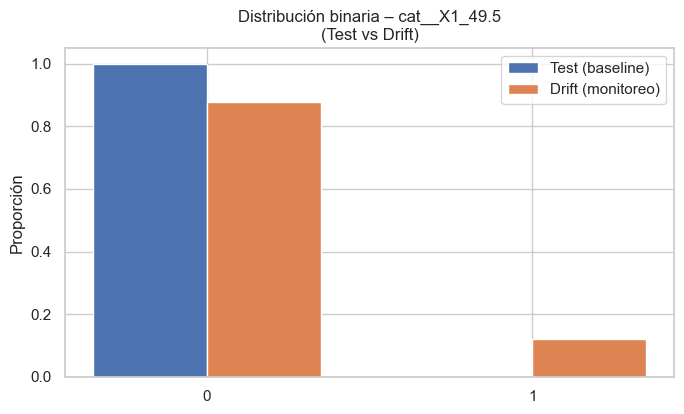

[OK] Guardado: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_binary_cat__X7_0.1.png


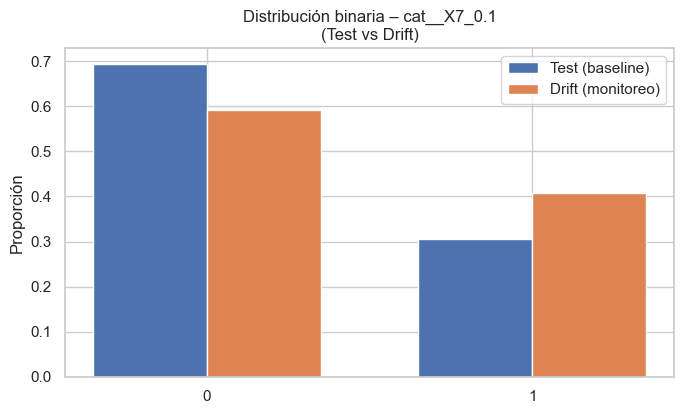

[OK] Guardado: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_binary_cat__X1_0.74.png


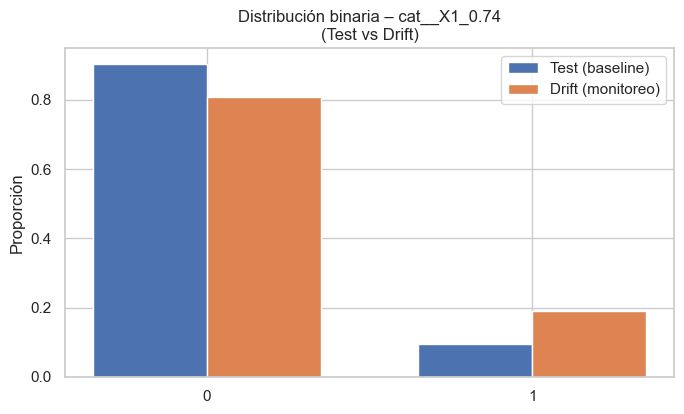

[OK] Guardado: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_binary_cat__X2_808.5.png


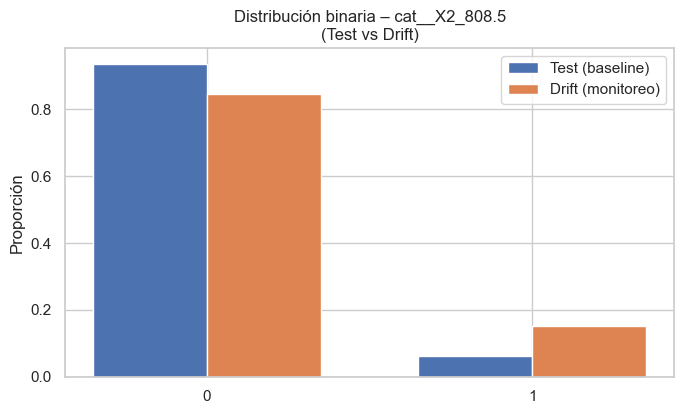

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

OUT_DIR = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def is_binary(s: pd.Series) -> bool:
    if not np.issubdtype(s.dtype, np.number): return False
    vals = pd.unique(s.dropna())
    return len(vals) <= 2 and set(np.round(vals,6)).issubset({0.0,1.0})

def is_lowcard_numeric(s: pd.Series) -> bool:
    return np.issubdtype(s.dtype, np.number) and (3 <= s.nunique(dropna=True) <= 15)

def is_continuous(s: pd.Series) -> bool:
    return np.issubdtype(s.dtype, np.number) and (s.nunique(dropna=True) > 15)

# Si existe drift_report, usa top-variables; si no, toma heurística
TOP_K = 4
if "drift_report" in globals():
    cand = drift_report.sort_values(
        by=["type", "p_value"], ascending=[True, True]
    )["feature"].tolist()
    features = [c for c in cand if c in X_test.columns][:max(TOP_K,4)]
else:
    features = X_test.columns.tolist()[:max(TOP_K,4)]

sns.set(style="whitegrid")

def plot_binary(col):
    base = X_test[col].dropna().astype(float)
    drift = X_drift[col].dropna().astype(float)
    p_base = base.mean() if len(base)>0 else np.nan
    p_drift = drift.mean() if len(drift)>0 else np.nan

    plt.figure(figsize=(7,4.3))
    x = np.arange(2)
    width = 0.35
    plt.bar(x - width/2, [1-p_base, p_base], width, label="Test (baseline)")
    plt.bar(x + width/2, [1-p_drift, p_drift], width, label="Drift (monitoreo)")
    plt.xticks(x, ["0","1"])
    plt.ylabel("Proporción")
    plt.title(f"Distribución binaria – {col}\n(Test vs Drift)")
    plt.legend(); plt.tight_layout()
    pth = OUT_DIR / f"viz_binary_{col}.png"
    plt.savefig(pth, dpi=150); print("[OK] Guardado:", pth)
    plt.show()

def plot_lowcard(col):
    base = X_test[col].dropna()
    drift = X_drift[col].dropna()
    cats = np.union1d(base.unique(), drift.unique())
    base_freq = pd.Series(base).value_counts(normalize=True).reindex(cats, fill_value=0)*100
    drift_freq = pd.Series(drift).value_counts(normalize=True).reindex(cats, fill_value=0)*100
    idx = np.arange(len(cats)); width = 0.40

    plt.figure(figsize=(8,4.8))
    plt.bar(idx - width/2, base_freq.values, width, label="Test (baseline)")
    plt.bar(idx + width/2, drift_freq.values, width, label="Drift (monitoreo)")
    plt.xticks(idx, [str(c) for c in cats], rotation=45, ha="right")
    plt.ylabel("Frecuencia (%)")
    plt.title(f"Distribución baja cardinalidad – {col}\n(Test vs Drift)")
    plt.legend(); plt.tight_layout()
    pth = OUT_DIR / f"viz_lowcard_{col}.png"
    plt.savefig(pth, dpi=150); print("[OK] Guardado:", pth)
    plt.show()

def plot_continuous(col):
    a = X_test[col].dropna().astype(float)
    b = X_drift[col].dropna().astype(float)

    plt.figure(figsize=(7,4.5))
    # KDE solo si hay varianza; si no, traza línea vertical
    if len(a)>1 and a.std(ddof=0)>0:
        sns.kdeplot(a, fill=True, alpha=0.45, linewidth=1.5, label="Test (baseline)", warn_singular=False)
    elif len(a)>0:
        plt.axvline(a.iloc[0], linestyle="--", label="Test (constante)")
    if len(b)>1 and b.std(ddof=0)>0:
        sns.kdeplot(b, fill=True, alpha=0.45, linewidth=1.5, label="Drift (monitoreo)", warn_singular=False)
    elif len(b)>0:
        plt.axvline(b.iloc[0], linestyle="-.", label="Drift (constante)")

    plt.title(f"Distribución – {col}\n(Test vs Drift)")
    plt.xlabel(col); plt.ylabel("Densidad")
    plt.legend(loc="best"); plt.tight_layout()
    pth = OUT_DIR / f"viz_density_{col}.png"
    plt.savefig(pth, dpi=150); print("[OK] Guardado:", pth)
    plt.show()

# --- Selección y visualización por tipo ---
for col in features:
    s_test = X_test[col]
    if is_binary(s_test):
        plot_binary(col)
    elif is_lowcard_numeric(s_test):
        plot_lowcard(col)
    elif is_continuous(s_test):
        plot_continuous(col)
    else:
        # fallback genérico
        plot_lowcard(col)


## Paso 4.5 Bis
(KDE-only): Graficar SOLO columnas aptas para KDE
Requisitos por columna: numérica, >= MIN_UNIQUE valores, std>0 en Test y Drift

## Paso 4.5 curvas suaves X1 y X2

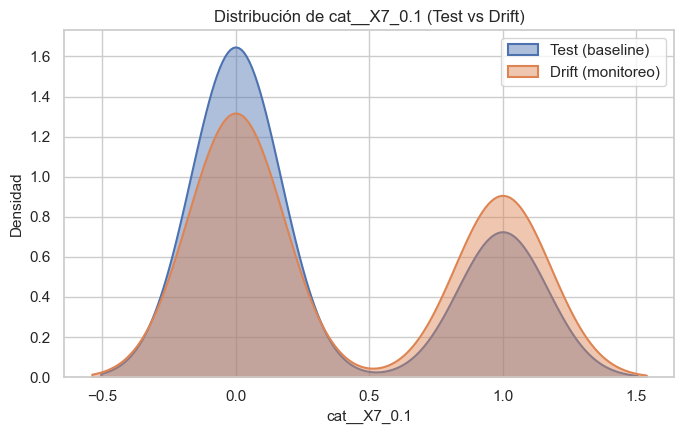

[OK] Gráfica guardada: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_kde_cat__X7_0.1_categorical.png


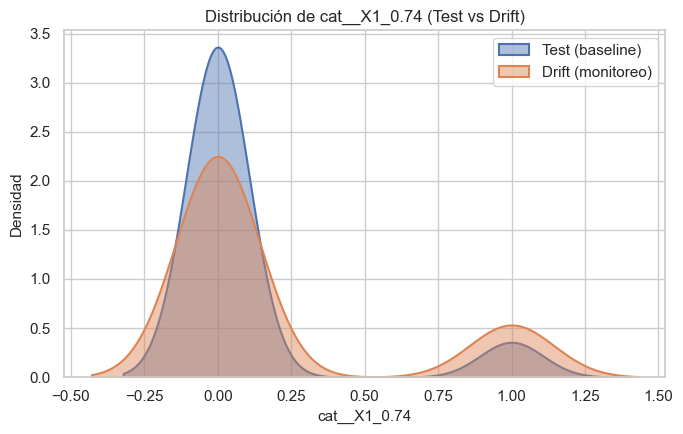

[OK] Gráfica guardada: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_kde_cat__X1_0.74_categorical.png


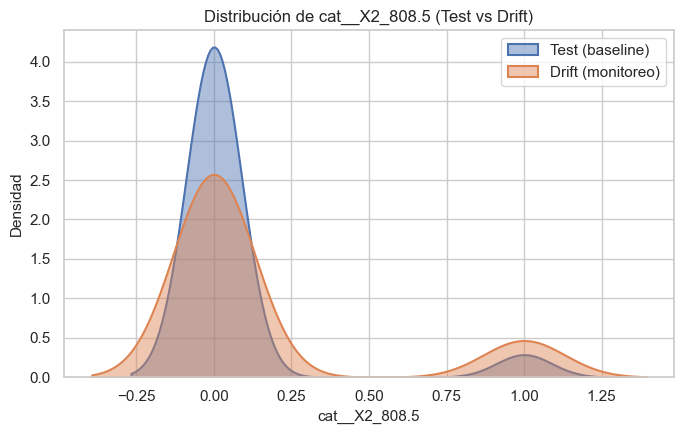

[OK] Gráfica guardada: C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed\viz_kde_cat__X2_808.5_categorical.png


In [58]:
# ================================================
# Gráficas KDE suavizadas para variables categóricas X1 y X2
# ================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Directorio de salida
OUT_DIR = Path(r"C:\Saul\Saul\Documentos\Personal\Maestria\ITESM\IA\Jupyter\TC5044\MLops_E38_Final\data\processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Variables seleccionadas
vars_categoricas = ["cat__X7_0.1", "cat__X1_0.74", "cat__X2_808.5"]  # Ajusta con los nombres reales de tus columnas

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

for c in vars_categoricas:
    if c not in X_test.columns or c not in X_drift.columns:
        print(f"[WARN] {c} no se encuentra en ambos datasets, se omite.")
        continue

    # Conversión a float para KDE
    test_vals = X_test[c].astype("category").cat.codes.astype(float)
    drift_vals = X_drift[c].astype("category").cat.codes.astype(float)

    plt.figure(figsize=(7, 4.5))
    sns.kdeplot(test_vals, fill=True, alpha=0.45, linewidth=1.5, label="Test (baseline)")
    sns.kdeplot(drift_vals, fill=True, alpha=0.45, linewidth=1.5, label="Drift (monitoreo)")

    plt.title(f"Distribución de {c} (Test vs Drift)")
    plt.xlabel(c)
    plt.ylabel("Densidad")
    plt.legend(loc="best")
    plt.tight_layout()

    out_path = OUT_DIR / f"viz_kde_{c}_categorical.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"[OK] Gráfica guardada: {out_path}")
